# Painter classification
### Author: Fan Wenxiao
### School: Beijing Institute of Technology

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
import numpy as np

First, we classify the problem. The problem of classification of painters is a process of supervising learning and a classification problem. So for such a problem, we used the more established model alexnet on the network for training. The final accuracy is stable at 85.41%.

Secondly, in this problem, there is a problem that the data set is too small, so we enhance the data set by means of random rotation and mirror flipping, and increase the size of the data set from 400 to 4000. This is conducive to the generalization of the model.

##### Load data that has been data-enhanced and convert it to a tensor.

In [0]:
data_transform = transforms.Compose([
        #transforms.Resize(299),
        #transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                    	     std=[0.5, 0.5, 0.5])
    ])
train_dataset = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/artist_distribute',transform=data_transform)
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=128, shuffle=True)

print(train_dataset.class_to_idx)
#print(len(train_dataset[0]))

{'canaletto': 0, 'claude_monet': 1, 'george_romney': 2, 'jmw_turner': 3, 'john_robert_cozens': 4, 'paul_cezanne': 5, 'paul_gauguin': 6, 'paul_sandby': 7, 'peter_paul_rubens': 8, 'rembrandt': 9, 'richard_wilson': 10}


##### Define the network structure.

Here we have modified alexnet to add batch normalization in front of the activation function for each layer in the convolutional layer. At the same time, two attention mechanisms are added to each layer of the convolutional layer. These two attention mechanisms come from Resnet-18.

In [0]:
# 添加注意力机制
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [0]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 96, 11, 4, 0),
            torch.nn.BatchNorm2d(96),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3,2)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(96, 256, 5, 1, 2),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3,2)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(256,384, 3, 1, 1),
            torch.nn.BatchNorm2d(384),
            torch.nn.ReLU()
            
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(384,384, 3, 1, 1),
            torch.nn.BatchNorm2d(384),
            torch.nn.ReLU()
            
        )
        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(384,256, 3, 1, 1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3,2)
            
        )
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(9216, 4096),
            #torch.nn.BatchNorm2d(4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 512),
            #torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            #torch.nn.BatchNorm2d(512),
            torch.nn.Linear(512, 11)
        )
        self.ca1 = ChannelAttention(24 * 4)
        self.ca2 = ChannelAttention(256)
        self.ca4 = ChannelAttention(256)
        self.ca3 = ChannelAttention(384)
        self.sa = SpatialAttention()
 
    def forward(self, x):
        conv1_out = self.conv1(x)
        conv1_out = self.ca1(conv1_out) * conv1_out
        conv1_out = self.sa(conv1_out) * conv1_out

        conv2_out = self.conv2(conv1_out)
        conv2_out = self.ca2(conv2_out) * conv2_out
        conv2_out = self.sa(conv2_out) * conv2_out

        conv3_out = self.conv3(conv2_out)
        conv3_out = self.ca3(conv3_out) * conv3_out
        conv3_out = self.sa(conv3_out) * conv3_out

        conv4_out = self.conv4(conv3_out)
        conv4_out = self.ca3(conv4_out) * conv4_out
        conv4_out = self.sa(conv4_out) * conv4_out


        conv5_out = self.conv5(conv4_out)
        conv5_out = self.ca4(conv5_out) * conv5_out
        conv5_out = self.sa(conv5_out) * conv5_out
        #conv5_out = self.ca(conv5_out)
        res = conv5_out.view(conv5_out.size(0), -1)
        out = self.dense(res)
        return out

In [0]:
na = Net()
print(na)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (con

##### Define the loss function and optimizer, and start training.

In [7]:
net = Net()
#net = torch.load('/content/drive/My Drive/Colab Notebooks/alexnet23.pkl')
net = net.cuda()
criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00005)
#ExponentialLR
optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.1, last_epoch=-1)
print("Start Training...")
LOSS = []
num_epoch = 30
for epoch in range(num_epoch):
    # 我们用一个变量来记录每10个batch的平均loss
    loss10 = 0.0
    # 我们的dataloader派上了用场
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        #print(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #print('a')
        #print(torch.cuda.current_device())
        loss10 += loss.item()
        if i % 10 == 9:
            print('[Epoch %d, Batch %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss10 / 10))
            LOSS.append(loss10/10)
            loss10 = 0.0

print("Done Training!")

Start Training...
[Epoch 1, Batch    10] loss: 2.494
[Epoch 1, Batch    20] loss: 1.802
[Epoch 1, Batch    30] loss: 1.603
[Epoch 2, Batch    10] loss: 1.368
[Epoch 2, Batch    20] loss: 1.214
[Epoch 2, Batch    30] loss: 1.113
[Epoch 3, Batch    10] loss: 0.958
[Epoch 3, Batch    20] loss: 0.932
[Epoch 3, Batch    30] loss: 0.803
[Epoch 4, Batch    10] loss: 0.742
[Epoch 4, Batch    20] loss: 0.719
[Epoch 4, Batch    30] loss: 0.715
[Epoch 5, Batch    10] loss: 0.657
[Epoch 5, Batch    20] loss: 0.623
[Epoch 5, Batch    30] loss: 0.659
[Epoch 6, Batch    10] loss: 0.568
[Epoch 6, Batch    20] loss: 0.570
[Epoch 6, Batch    30] loss: 0.522
[Epoch 7, Batch    10] loss: 0.485
[Epoch 7, Batch    20] loss: 0.516
[Epoch 7, Batch    30] loss: 0.477
[Epoch 8, Batch    10] loss: 0.425
[Epoch 8, Batch    20] loss: 0.388
[Epoch 8, Batch    30] loss: 0.375
[Epoch 9, Batch    10] loss: 0.281
[Epoch 9, Batch    20] loss: 0.336
[Epoch 9, Batch    30] loss: 0.292
[Epoch 10, Batch    10] loss: 0.249
[

##### Evaluation

In [8]:
# In[eval]
test_dataset = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/test_set',transform=data_transform)
testloader = torch.utils.data.DataLoader(test_dataset,batch_size=46, shuffle=True)
eval_loss = 0
correct = 0
total = 0
for i, data in enumerate(testloader):
    inputs, labels = data
    inputs = inputs.cuda()
    labels = labels.cuda()
    #print(labels)
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    eval_loss += loss.item()
    total += labels.size(0)
    pred = torch.max(outputs, 1)[1]
    print('pred: ',pred,' labels: ',labels)
    correct += (pred == labels).sum().item()
print('eval_loss: ',eval_loss)
print('correct: ',correct)
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

pred:  tensor([ 3,  4,  4, 10,  7,  4,  2,  5,  6,  6,  8,  1,  2,  5,  3,  5,  9,  2,
         1,  1,  2,  4,  8,  3,  1, 10,  3,  4, 10,  0,  1,  6,  0,  3,  9,  1,
         9,  9,  7,  3,  9,  2,  5,  2,  2, 10], device='cuda:0')  labels:  tensor([ 3,  4,  3,  3,  7,  4,  2,  1,  6,  6,  5,  1,  2,  5,  3,  5,  8,  2,
         1,  1,  2,  4,  8,  3,  1, 10,  3,  4,  3,  0,  7,  6,  0,  3,  9,  1,
         9,  9,  7,  3,  9,  2,  5,  2,  2, 10], device='cuda:0')
eval_loss:  1.051384449005127
correct:  39
Accuracy of the network on the test images: 84 %


In [9]:
summ = 0
for ii in range(100):
  test_dataset = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/test_set',transform=data_transform)
  testloader = torch.utils.data.DataLoader(test_dataset,batch_size=46, shuffle=True)
  eval_loss = 0
  correct = 0
  total = 0
  for i, data in enumerate(testloader):
    inputs, labels = data
    #print(labels)
    
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    eval_loss += loss.item()
    total += labels.size(0)
    pred = torch.max(outputs, 1)[1]
    print('pred: ',pred,' labels: ',labels)
    correct += (pred == labels).sum().item()
    summ += (100 * correct / total)
  print('eval_loss: ',eval_loss)
  print('correct: ',correct)
  print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
print("total_acc: ", summ/100)

pred:  tensor([ 1,  3,  5,  5,  9,  2,  5,  0,  1,  3,  0,  4,  6,  9,  4,  9,  3,  2,
         3,  6,  2,  2,  1,  7,  7,  3, 10,  1, 10,  6,  8,  5, 10,  4,  6,  1,
         8,  4,  9,  2,  1,  3, 10,  2,  9,  2], device='cuda:0')  labels:  tensor([ 7,  3,  5,  5,  8,  2,  5,  0,  1,  3,  0,  4,  3,  9,  4,  9,  3,  2,
         3,  6,  2,  2,  1,  7,  7,  3,  3,  1, 10,  6,  5,  1,  3,  4,  6,  1,
         8,  4,  9,  2,  1,  3, 10,  2,  9,  2], device='cuda:0')
eval_loss:  1.3486568927764893
correct:  39
Accuracy of the network on the test images: 84 %
pred:  tensor([ 7,  2,  1,  2,  3,  2,  5,  8,  1,  2,  9,  4, 10,  4,  9,  1,  2,  0,
         7,  6,  4,  1,  2, 10,  8,  2,  5,  3,  3,  9,  9,  3, 10,  3,  6,  9,
         3,  4, 10,  1,  0,  1,  1,  6,  4,  5], device='cuda:0')  labels:  tensor([ 7,  2,  1,  2,  3,  2,  5,  8,  7,  2,  9,  4,  3,  3,  9,  1,  2,  0,
         7,  6,  4,  1,  2,  3,  5,  2,  5,  3,  3,  8,  9,  3, 10,  3,  6,  9,
         3,  4, 10,  1,  0,  1,  1,

##### Visualization of training error.

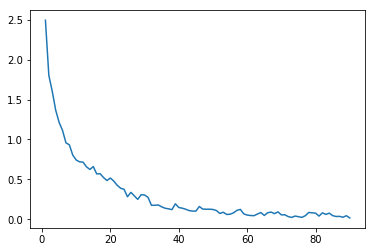

In [10]:
# In[可视化]
from matplotlib import pyplot as plt
x = np.linspace(1,len(LOSS),len(LOSS))
plt.plot(x,LOSS)
plt.show()

###### It can be seen that the exact interest rate of our model is stable at 85.41%, which is equivalent to only 6 pictures in the 46 pictures of the test set.

###### Advantages of the model: less convolution layer and less training.